<a href="https://colab.research.google.com/github/Sirfowahid/BrainStrokeDetection/blob/main/BrainStrokePredAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

# Importing libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


In [ ]:
# Hyperparameters
num_epochs = 25
batch_size = 32
learning_rate = 1e-3

In [ ]:
# Model checkpoint path
checkpoint_path = '/content/drive/MyDrive/Projects/23. Brain Stroke Prediction/modelWeight/best_model.pth'


In [ ]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Datasets
train_dir = '/content/drive/MyDrive/Projects/23. Brain Stroke Prediction/Dataset'
test_dir = '/content/drive/MyDrive/Projects/23. Brain Stroke Prediction/Dataset'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [ ]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [ ]:
# Automatically detect number of classes from the dataset
num_classes = len(train_dataset.classes)
print(f'Number of classes: {num_classes}')
classes = train_dataset.classes
print(f'Classes: {classes}')


Number of classes: 5
Classes: ['Acute Stroke', 'Cerebral Hemorrhage', 'Fatal Stroke', 'Multiple Embolic Infarctions', 'Non Stroke']


In [ ]:
# Define Custom CNN Model for Multiclass Classification
class BioClassNet(nn.Module):
    def __init__(self):
        super(BioClassNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = BioClassNet().to(device)

In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Initialize best validation accuracy
best_val_acc = 0.0

# Check if checkpoint exists
if os.path.exists(checkpoint_path):
    print(f"Loading saved model from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_val_acc = checkpoint.get('best_val_acc', 0.0)
    print(f"Loaded model with best validation accuracy: {best_val_acc:.4f}")
else:
    print("No saved model found. Starting training...")

    # Training and Validation Loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training', leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            loop = tqdm(test_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation', leave=False)
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / len(test_dataset)
        epoch_val_acc = val_correct / val_total
        test_losses.append(epoch_val_loss)
        test_accuracies.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} '
              f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

        # Check if this is the best validation accuracy so far
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            print(f'New best validation accuracy: {best_val_acc:.4f}. Saving model...')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc
            }, checkpoint_path)

    # Plot Loss and Accuracy
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, test_losses, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, 'b', label='Training acc')
    plt.plot(epochs, test_accuracies, 'r', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()






Loading saved model from /content/drive/MyDrive/Projects/23. Brain Stroke Prediction/modelWeight/best_model.pth
Loaded model with best validation accuracy: 0.9336


In [ ]:
# Evaluation Metrics on Test Set
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)


In [ ]:
print("\nEvaluation Metrics:")
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall   : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')


Evaluation Metrics:
Accuracy : 0.9336
Precision: 0.9312
Recall   : 0.9336
F1 Score : 0.9298


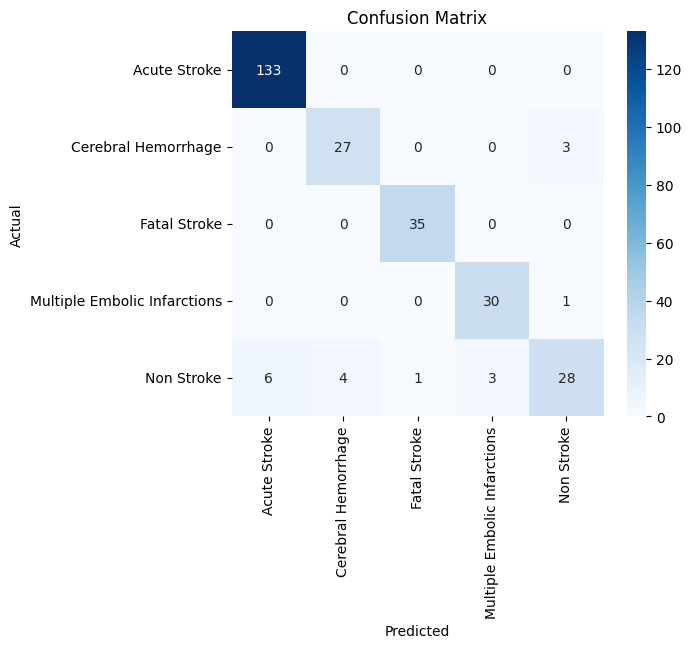

In [ ]:
# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


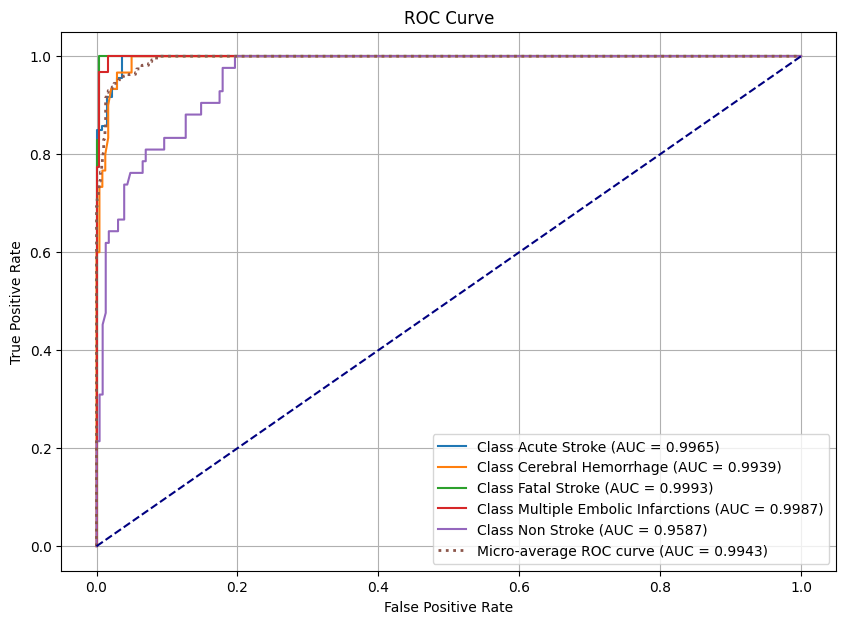

In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np
# Binarize the labels for ROC curve
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))

# Get probabilities for each class
all_probs = []

model.eval()
with torch.no_grad():
    for inputs, _ in tqdm(test_loader, desc='Testing (for ROC)', leave=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities using softmax
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = roc_auc_score(all_labels_bin[:, i], all_probs[:, i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = roc_auc_score(all_labels_bin, all_probs, average="micro")

# Plot ROC curve
plt.figure(figsize=(10, 7))

# Plot each class's ROC curve
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.4f})',
         linestyle=':', linewidth=2)

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
from google.colab import files
from PIL import Image, ImageEnhance, ImageDraw
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Initialize YOLO model
yolo = YOLO("/content/drive/MyDrive/Projects/23. Brain Stroke Prediction/best.pt")

# Function to predict and plot a single image
def predict_image(image_path, model, transform, device):
    # Load and enhance contrast of the image
    image = Image.open(image_path).convert("RGB")  # Ensure RGB format
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.5)  # Increase contrast by 1.5x

    # Run YOLO prediction
    results = yolo.predict(image, conf=0.1)
    boxes = results[0].boxes  # Extract bounding boxes from YOLO results

    # Transform image for the classifier model
    image_tensor = transform(image).unsqueeze(0).to(device)  # Transform and move to device

    # Set model to evaluation mode
    model.eval()

    # Get classification prediction
    with torch.no_grad():
        output = model(image_tensor)
    prob = torch.softmax(output, dim=1)
    prediction = torch.argmax(prob, dim=1).item()

    return prob, prediction, image, boxes  # Return image for plotting

# Upload an image from the local device
uploaded = files.upload()

# Get the image filename
image_path = list(uploaded.keys())[0]
print(f"Uploaded file: {image_path}")

# Define the transformation (same as used for training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the best saved model checkpoint (if not already loaded)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Predict the uploaded image
probability, predicted_class, image, boxes = predict_image(image_path, model, transform, device)

# Output the prediction
class_name = classes[predicted_class]
print(f"Predicted class: {class_name}")

# Draw bounding boxes on the image
draw = ImageDraw.Draw(image)
for box in boxes:
    x1, y1, x2, y2 = box.xyxy[0]  # Get the box coordinates
    draw.rectangle(((x1, y1), (x2, y2)), outline="red", width=3)  # Draw bounding box

    # Convert tensor to float and format confidence score
    score = float(box.conf)  # Convert tensor to float
    draw.text((x1, y1), f"{score:.2f}", fill="red")

# Display the image with bounding boxes and predicted class
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted class: {class_name}')
plt.show()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
